# Neural Network for Binary Classification of Stress
- There will be two classes: Stress and Rest. This is achieved by combining the S1 and S2 class into one class, Stress
- This network will aim to use all the signals extracted from the data collection.


In [287]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal
import heartpy as hp
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [288]:
# Compilation Options
CLASS_WEIGHTS = True

In [289]:
# Specify the path to your CSV file
file_path = 'filtered_stress_data.csv'

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

# Specify the columns you want to extract
columns_to_extract = ['user_id', 'classification', 'chest_coil', 'abdomen_coil']
features = ['chest_coil', 'abdomen_coil']

# Extract the specified columns
extracted_columns = data[columns_to_extract]

# Drop any rows with missing data
extracted_columns = extracted_columns.dropna()

# Check for non-numeric values in each feature and replace them with NaNs
for feature in features:
    extracted_columns[feature] = pd.to_numeric(extracted_columns[feature], errors='coerce')

# Check if there are any NaNs in the dataset after replacing non-numeric values
if extracted_columns.isnull().values.any():
    print("NaNs detected after attempting to convert non-numeric values to float. Please check the data.")
    # Handle NaNs based on your requirements, such as removing rows with NaNs or imputing missing values
    # For this example, we will remove rows with NaNs
    extracted_columns = extracted_columns.dropna()

# Filter data 
extracted_columns['chest_coil'] = scipy.signal.detrend(extracted_columns['chest_coil'] )
extracted_columns['chest_coil']  = hp.filter_signal(extracted_columns['chest_coil'] , cutoff=1, sample_rate=20.0, filtertype='lowpass', return_top=False)

extracted_columns['abdomen_coil']  = scipy.signal.detrend(extracted_columns['abdomen_coil'] )
extracted_columns['abdomen_coil']  = hp.filter_signal(extracted_columns['abdomen_coil'] , cutoff=1, sample_rate=20.0, filtertype='lowpass', return_top=False)

print(extracted_columns["abdomen_coil"].shape)
print(extracted_columns["chest_coil"].shape)

# Ensure we are using the cleaned data for further processing
data = extracted_columns

# Combine S1 and S2 classes into one "Stress" class
data['classification'] = data['classification'].replace({'S1': 'Stress', 'S2': 'Stress'})

print(data['classification'].value_counts())
print(data['classification'].unique())

(175214,)
(175214,)
classification
Stress    116245
Rest       58969
Name: count, dtype: int64
['Stress' 'Rest']


In [290]:
# Feature Extraction
# Extract features and labels
X = data[['chest_coil', 'abdomen_coil']].values
y = data['classification'].values
user_ids = data['user_id'].values

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(label_encoder.classes_)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data into sequences
time_step_length = 100  
num_samples = len(X_scaled) // time_step_length

X_sequences = np.array([X_scaled[i*time_step_length:(i+1)*time_step_length] for i in range(num_samples)])
y_sequences = np.array([y[i*time_step_length] for i in range(num_samples)])
user_id_sequences = np.array([user_ids[i*time_step_length] for i in range(num_samples)])

['Rest' 'Stress']


In [291]:
# Split the data into training and testing sets based on user_id to avoid data leakage
gkf = GroupKFold(n_splits=5)
for train_index, test_index in gkf.split(X_sequences, y_sequences, groups=user_id_sequences):
    X_train, X_test = X_sequences[train_index], X_sequences[test_index]
    y_train, y_test = y_sequences[train_index], y_sequences[test_index]
    break  # Use the first split

# Check the shape of the reshaped data
print(X_train.shape)  # Should be (num_samples, time_step_length, num_features)
print(X_test.shape)

(1384, 100, 2)
(368, 100, 2)


In [292]:
# Compute class weights
if CLASS_WEIGHTS:
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))

In [293]:
# Define the CNN model
model = Sequential([
    Input(shape=(time_step_length, X_train.shape[2])),
    Conv1D(32, 3, activation='relu', padding='same'),
    MaxPooling1D(2),
    BatchNormalization(),
    Conv1D(64, 3, activation='relu', padding='same'),
    MaxPooling1D(2),
    BatchNormalization(),
    Conv1D(128, 3, activation='relu', padding='same'),
    MaxPooling1D(2),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and learning rate scheduler
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for learning rate adjustment and early stopping
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

if CLASS_WEIGHTS:
    # Train the model with class weights
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                        class_weight=class_weights_dict, callbacks=[lr_reduction, early_stopping])
else:
    # Train the model without class weights 
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[lr_reduction, early_stopping])



Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6698 - loss: 0.8380 - val_accuracy: 0.1223 - val_loss: 1.1017 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7199 - loss: 0.6038 - val_accuracy: 0.1929 - val_loss: 1.2389 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7147 - loss: 0.6045 - val_accuracy: 0.2446 - val_loss: 0.9896 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7603 - loss: 0.4809 - val_accuracy: 0.1685 - val_loss: 1.8718 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7629 - loss: 0.4658 - val_accuracy: 0.2065 - val_loss: 1.6696 - learning_rate: 0.0010
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7739 - loss: 0.4191 - val_accuracy: 0.2092 - val_loss: 2.8136 - learning_rate: 0.0010
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8103 - loss: 0.3785 - val_accu

In [294]:
# Binary Classification
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3927 - loss: 0.8454 
Test Accuracy: 0.2445652186870575


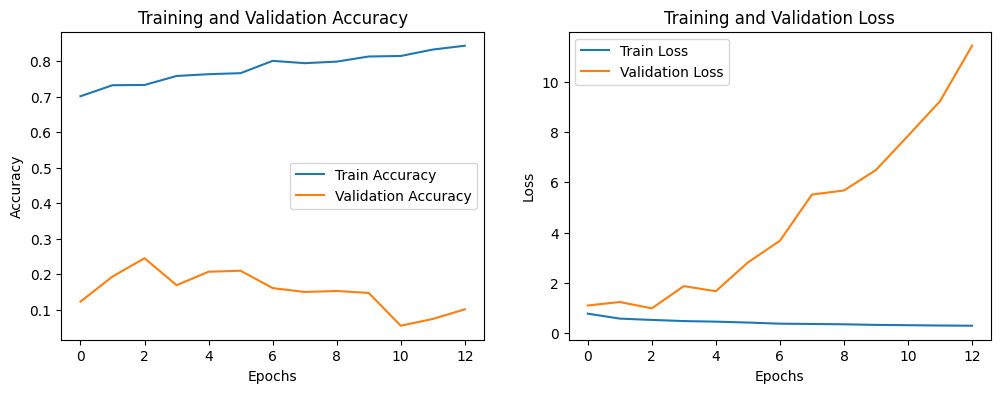

In [295]:
# Plotting training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


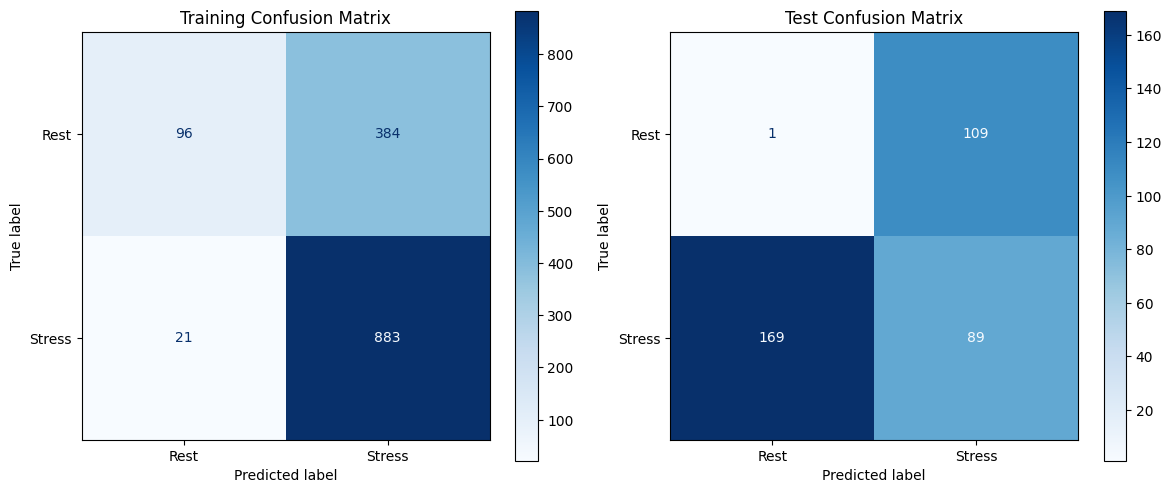

In [296]:
# Evaluate the model on training data to get training predictions
y_train_pred = (model.predict(X_train) > 0.5).astype("int32")

# Evaluate the model on test data to get test predictions
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")

# Confusion matrix for training data
train_cm = confusion_matrix(y_train, y_train_pred)
train_cmd = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=label_encoder.classes_)

# Confusion matrix for test data
test_cm = confusion_matrix(y_test, y_test_pred)
test_cmd = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=label_encoder.classes_)

# Plot confusion matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_cmd.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Training Confusion Matrix')

plt.subplot(1, 2, 2)
test_cmd.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Test Confusion Matrix')

plt.tight_layout()
plt.show()
